In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers
!cp /content/drive/MyDrive/fake-news-explainability/utils_fake_news.py .
!git clone https://github.com/fhvilshoj/TorchLRP.git

In [ ]:
!cp TorchLRP/examples/utils.py .
!cp TorchLRP/examples/visualization.py .

In [ ]:
import pandas as pd
import numpy as np
import json, re, os
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.insert(1, '/content/TorchLRP')


## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# LRP
import lrp
from utils import get_mnist_model, prepare_mnist_model, get_mnist_data
from utils import store_patterns, load_patterns
from visualization import heatmap_grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive

# Encoding and Utils
%run utils_fake_news.py

# Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Data Preprocessing

In [ ]:
# Load the Fake-News Kaggle dataset
df_train = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news.csv")
df_train = df_train.dropna(subset=['statement'])

# Encode dataframes using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train['statement'])
vocab = vectorizer.get_feature_names()

# Convert to sparse PyTorch matrix
X = X.tocoo()
X = torch.sparse.FloatTensor(torch.LongTensor([X.row.tolist(), X.col.tolist()]),
                             torch.FloatTensor(X.data.astype(np.float)))

# Feed as TensorDataset
df_encode = TensorDataset(X, torch.LongTensor(df_train['label']))

## Model & Training Function

In [ ]:
import torch.nn as nn
from transformers import AutoModel

def train():
    total_t0 = time.time()
    for epoch_i in range(0, epochs):
        
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        bert_model.train()

        for step, batch in enumerate(bert_train_dataloader):
            # Unpack batch
            b_input = batch[0].to(device)
            b_labels = batch[1].to(device)

            # Zero grads
            bert_model.zero_grad()        

            # Forward pass
            output = bert_model(b_input)
            
            # Accumulate loss
            loss = loss_func(output.squeeze(1), b_labels)
            
            # Backpropagate
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            # torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The bert_optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            bert_optimizer.step()

            # Update the learning rate.
            bert_scheduler.step()

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
                print(f'Loss: {loss.detach()}')
                
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(bert_train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # Record all statistics from this epoch.
        bert_training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                # 'Valid. Loss': avg_val_loss,
                # 'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                # 'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Load Data

In [ ]:
# Load data into dataloader
batch_size = 32
bert_train_dataloader = DataLoader(
    df_encode,  # The training samples.
    batch_size = batch_size # Trains with this batch size.
    )

## Training

In [ ]:
# Model
vocab_size = X.shape[1]
bert_model = lrp.Sequential(
                     lrp.Linear(vocab_size, 153),
                     torch.nn.ReLU(),
                     lrp.Linear(153,32),
                     torch.nn.ReLU(),
                     lrp.Linear(32,2)
                 ).to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-3, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
# Training Params
bert_training_stats = []
epochs = 2
total_steps = len(bert_train_dataloader) * epochs
loss_func = nn.CrossEntropyLoss()

# Learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps = 0, # Default value in run_glue.py
                                                 num_training_steps = total_steps)

In [ ]:
# Train or load pre-trained
tfidf_model = "/content/drive/MyDrive/fake-news-explainability/Models/fake_news_model_tfidf"

if os.path.exists(tfidf_model):
    bert_model.load_state_dict(torch.load(tfidf_model, map_location=device))
else:
    train()
    torch.save(bert_model.state_dict(), tfidf_model)

## Evaluate (On Fake-News Train Set)

In [ ]:
with torch.no_grad():
    outputs = bert_model.forward(X.to(device))
    print(f"Acc: {flat_accuracy(outputs.detach().cpu().numpy(), df_encode.tensors[1].to('cpu').numpy())}")

## Adversarial Attack Evaluation

In [ ]:
def encode_tfidf(path_csv, vectorizer=vectorizer):
  # Load the dataset
  df_encode = pd.read_csv(path_csv)
  df_encode = df_encode.dropna(subset=['statement'])

  if 'accept' in df_encode.columns:
    df_encode = df_encode.loc[df_encode.accept==1].reset_index(drop=True)
    
  # Encode using TF-IDF
  X = vectorizer.transform(df_encode['statement'])
  return torch.Tensor(X.toarray())

In [ ]:
# Load encoded tensors
# df_pos_encode = encode_tfidf("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_pos.csv")
# df_neg_encode = encode_tfidf("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_neg.csv")

df_pos_encode = encode_tfidf("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_name_orig_filtered.csv")
df_neg_encode = encode_tfidf("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_name_new_filtered.csv")

# df_pos_encode = encode_tfidf("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_polarity_orig_filtered.csv")
# df_neg_encode = encode_tfidf("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_polarity_new_filtered.csv")

# Generate predictions
with torch.no_grad():
    outputs_pos = bert_model.forward(df_pos_encode.to(device))
    outputs_neg = bert_model.forward(df_neg_encode.to(device))

In [ ]:
# Percent Labels Flipped
cf_matrix = confusion_matrix(torch.argmax(outputs_pos.cpu(), axis=1), 
                             torch.argmax(outputs_neg.cpu(), axis=1))
print(f"Labels Flipped: {cf_matrix[0,1]+cf_matrix[1,0]} of {np.sum(cf_matrix)} ({round(100*(cf_matrix[0,1]+cf_matrix[1,0])/np.sum(cf_matrix),4)}%)")

Labels Flipped: 6 of 248 (2.4194%)


In [ ]:
# Average Probability Change
m = nn.Softmax(dim=1)
delta_lst = m(outputs_neg)[:,1]-m(outputs_pos)[:,1]
print(f"Average Change: {round(float(torch.mean(delta_lst)),4)} ({round(float(torch.std(delta_lst)),4)})")

Average Change: 0.0195 (0.1155)


## LRP Explanations

In [ ]:
all_patterns_path = '/content/drive/MyDrive/fake-news-explainability/TorchLRP-master/examples/patterns/pattern_all.pkl'
if not os.path.exists(all_patterns_path):
    patterns_all = fit_patternnet(bert_model, bert_train_dataloader, device=device)
    store_patterns(all_patterns_path, patterns_all)
    !cp TorchLRP/examples/patterns/pattern_all.pkl drive/MyDrive/fake-news-explainability/TorchLRP-master/examples/patterns
else:
    patterns_all = [torch.tensor(p, device=device, dtype=torch.float32) for p in load_patterns(all_patterns_path)]

In [ ]:
def generate_explanations(lst):
    # Vectorize the input
    X = vectorizer.transform(lst).todense()

    # To PyTorch
    X = torch.Tensor(X)

    # Format sample data from positive class
    X = X.requires_grad_(True)
    X.grad = None

    # Make prediction
    y_hat = bert_model.forward(X.to(device), explain=True, rule="alpha2beta1")
    preds = y_hat
    y_hat = y_hat[range(X.shape[0]), y_hat.max(1)[1]] # Choose maximizing output neuron
    y_hat = y_hat.sum()

    # Backward pass (do explanation)
    y_hat.backward()
    explanation = X.grad
    
    return explanation, preds

# Get the vocab with the top 10 highest explanation scores (by magnitude)
def top_k_explanations(explanation, k, vocab=vocab, manual_keys=[]):
    
    n_obs = explanation.shape[0]
    
    # Collect top k indices
    explanation_idx = torch.topk(torch.abs(explanation), k=k, dim=1).indices
    
    # Manually add any selected words' indices
    for word in manual_keys:
        if word in vocab:
            explanation_idx = torch.hstack((explanation_idx,
                                            torch.tensor([vocab.index(word)])\
                                                 .repeat(n_obs,1)))
        else:
            print(f"'{word}' not in vocab")
    
    # Get their magnitudes
    explanation_val = torch.vstack([explanation[i][explanation_idx[i]] for i in range(n_obs)])
    
    # Get corresponding vocab
    explanation_key = [[vocab[idx] for idx in explanation_idx[i]] for i in range(n_obs)]
    return explanation_val, explanation_key

def as_pyplot_figure(vals, names, title=''):
    """Returns the explanation as a pyplot figure.
    Will throw an error if you don't have matplotlib installed
    Args:
        label: desired label. If you ask for a label for which an
                explanation wasn't computed, will throw an exception.
                Will be ignored for regression explanations.
        kwargs: keyword arguments, passed to domain_mapper
    Returns:
        pyplot figure (barchart).
    """
    import matplotlib.pyplot as plt
    vals, names = vals[::-1], names[::-1]
    fig = plt.figure()
    colors = ['orange' if x > 0 else 'blue' for x in vals]
    pos = np.arange(len(vals)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    main_title = title if title else 'Local Explanation'
    plt.title(main_title)
    plt.xlabel('LRP Score')

In [ ]:
import textwrap
plt.rcParams.update({'font.size': 12})
def explain(s, k=10, manual_keys=[], return_vals=False):
    explanation, pred = generate_explanations([s])
    vals, names = top_k_explanations(explanation, 
                                     k=min(len(s.split())-1,k), 
                                     manual_keys=manual_keys)
    softmax = nn.Softmax(dim=1)
    for i in range(len(vals)):
        p = pred[i].detach().cpu()
        prob = float(softmax(p.unsqueeze(0))[0][1])*100
        s = s.capitalize()
        sentence = '\n'.join(textwrap.wrap(s, 50))
        
        if return_vals:
            return vals[i].tolist(), names[i]
        as_pyplot_figure(vals = vals[i].tolist(), 
                         names = names[i], 
                         title = sentence.strip() + f"\n(Prediction: {round(prob,3)}% Fake)")


## Name Changing

In [ ]:
myfile = open("fake_news.txt", "r")
myline = myfile.readline()
corpus = []
while myline:
    corpus.append(myline)
    myline = myfile.readline()
myfile.close()   

In [ ]:
# How many of the LRP scores associated with 'Trump' were positive
corpus_trump = [c for c in corpus if 'trump' in c.lower()]
explain_trump = [explain(c,20,return_vals=True) for c in corpus_trump]
explain_trump = [{word:val for (val,word) in zip(item[0],item[1])} for item in explain_trump]
vals_trump = np.array([i['trump'] for i in explain_trump if 'trump' in i])
np.sum(vals_trump>0), len(vals_trump), np.mean(vals_trump>0)

(113, 117, 0.9658119658119658)

In [ ]:
# How many of the LRP scores associated with 'Donald' were negative
corpus_donald = [c for c in corpus if 'donald' in c.lower()]
explain_donald = [explain(c,20,return_vals=True) for c in corpus_donald]
explain_donald = [{word:val for (val,word) in zip(item[0],item[1])} for item in explain_donald]
vals_donald = np.array([i['donald'] for i in explain_donald if 'donald' in i])
np.sum(vals_donald<0), len(vals_donald), np.mean(vals_donald<0)

(63, 69, 0.9130434782608695)

In [ ]:
# How many of the LRP scores associated with 'Hillary' were negative
corpus_hillary = [c for c in corpus if 'hillary' in c.lower()]
explain_hillary = [explain(c,20,return_vals=True) for c in corpus_hillary]
explain_hillary = [{word:val for (val,word) in zip(item[0],item[1])} for item in explain_hillary]
vals_hillary = np.array([i['hillary'] for i in explain_hillary if 'hillary' in i])
np.sum(vals_hillary<0), len(vals_hillary), np.mean(vals_hillary<0)

(19, 20, 0.95)

Examples where Hillary is negative

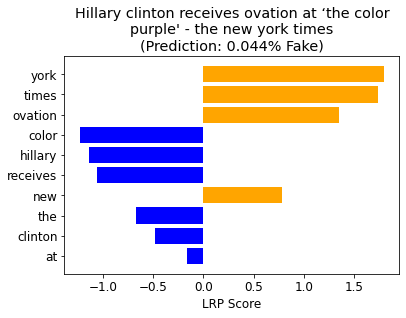

In [ ]:
explain(corpus_hillary[3], 10)

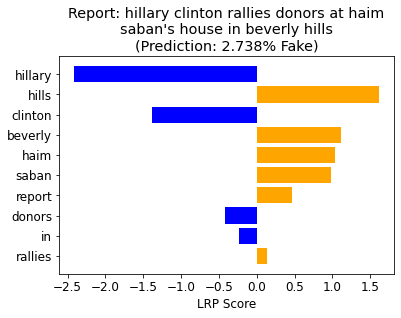

In [ ]:
explain(corpus_hillary[10], 10)

Examples where Trump is positive

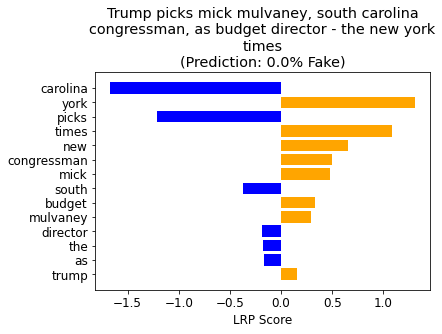

In [ ]:
explain(corpus_trump[np.where(vals_trump>0)[0][6]], 15)

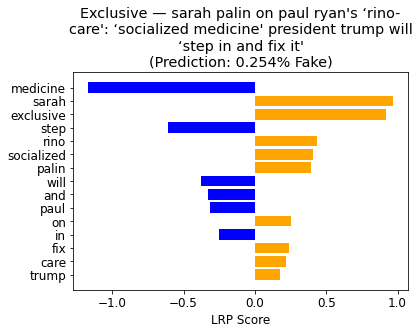

In [ ]:
explain(corpus_trump[np.where(vals_trump>0)[0][10]], 15)

Examples where Donald is negative, Trump is positive

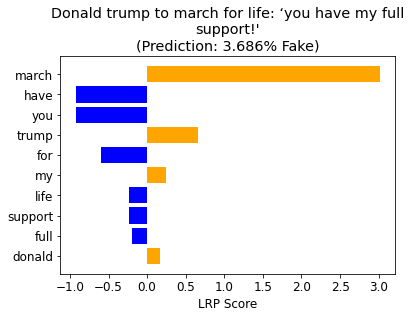

In [ ]:
explain(corpus_trump[np.where(vals_trump>0)[0][2]], 12)

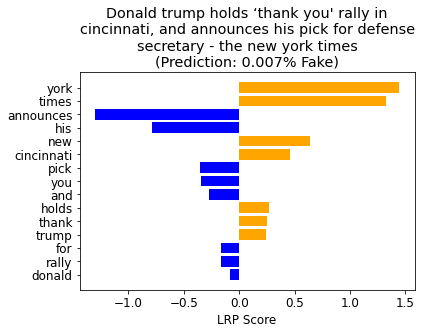

In [ ]:
explain(corpus_trump[np.where(vals_trump>0)[0][3]], 15)

## Polarity Changing

In [ ]:
df_orig = pd.read_csv('/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_polarity_orig.csv')
df_new  = pd.read_csv('/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_polarity_new.csv')

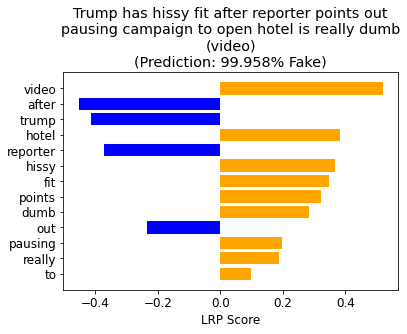

In [ ]:
# Trump has hissy fit after reporter points out pausing
# campaign to open hotel is really dumb (video)
explain(df_orig['statement'][13], k=13)

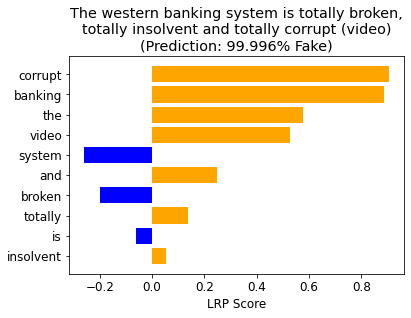

In [ ]:
# The western banking system is totally broken, totally insolvent, 
# and totally corrupt
explain(df_orig['statement'][9])

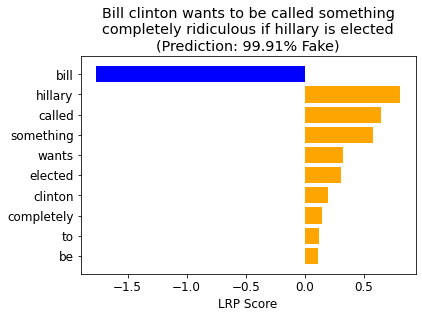

In [ ]:
# Bill Clinton wants to be called something completely
# ridiculous if Hillary is elected
explain(df_orig['statement'][4])

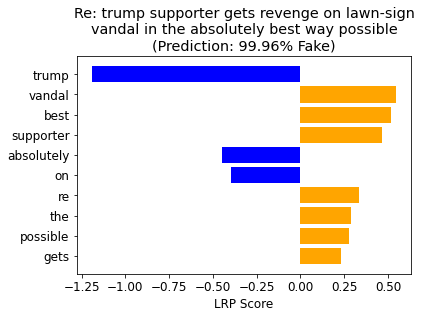

In [ ]:
explain(df_orig['statement'][18])